# Cartpole Problem

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \dot{x} & \theta & \dot{\theta}
    \end{bmatrix}^T
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}^T
\end{equation*}
$$

The goal is to swing the pendulum upright:

$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & 0 & 0
    \end{bmatrix}^T
\end{equation*}
$$

**Note**: The force is constrained between $-1$ and $1$. This is achieved by
instead fitting for unconstrained actions and then applying it to a squashing
function $\tanh(\textbf{u})$. This is directly embedded into the dynamics model
in order to be auto-differentiated. This also means that we need to apply this
transformation manually to the output of our iLQR at the end.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from ilqr import iLQR
from ilqr.cost import QRCost
from ilqr.dynamics import constrain
from ilqr.examples.cartpole import CartpoleDynamics

In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = dynamics.reduce_state(xs[-1])
    print("iteration", iteration_count, info, J_opt, final_state)

In [6]:
dt = 0.05
dynamics = CartpoleDynamics(dt)

In [7]:
# Note that the augmented state is not all 0.
x_goal = dynamics.augment_state(np.array([0.0, 0.0, 0.0, 0.0]))

# Instantenous state cost.
Q = 100 * np.eye(dynamics.state_size)
Q[1, 1] = Q[4, 4] = 10.0

# Terminal state cost.
Q_terminal = 100 * np.eye(dynamics.state_size)

# Instantaneous control cost.
R = np.array([[1.0]])

cost = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=x_goal)

In [8]:
N = 500
x0 = dynamics.augment_state(np.array([0.0, 0.0, np.pi, 0.0]))
us_init = np.random.uniform(-1, 1, (N, dynamics.action_size))
ilqr = iLQR(dynamics, cost, N)

In [9]:
J_hist = []
xs, us = ilqr.fit(x0, us_init, n_iterations=500, on_iteration=on_iteration)

iteration 0 accepted 188517.851143 [-0.01924817  0.11674071 -0.22354963  0.17287372]
iteration 1 accepted 188236.522086 [-0.03863816  0.09950345 -0.19975855  0.20152553]
iteration 2 accepted 187978.178513 [-0.02978798  0.10312388 -0.20355724  0.19152181]
iteration 3 accepted 187733.109725 [-0.03210938  0.10296346 -0.19742988  0.19184258]
iteration 4 accepted 187497.370794 [-0.02921515  0.10469679 -0.19565265  0.18979045]
iteration 5 accepted 187269.69161 [-0.03063459  0.10500978 -0.19079069  0.19054081]
iteration 6 accepted 187048.713341 [-0.02900152  0.10704482 -0.1875029   0.1913218 ]
iteration 7 accepted 186834.018503 [-0.03022647  0.10733023 -0.18350408  0.19221803]
iteration 8 accepted 186624.962003 [-0.02908229  0.11055176 -0.17878627  0.19628122]
iteration 9 accepted 186421.260512 [-0.03062564  0.11025419 -0.17568056  0.19692103]
iteration 10 accepted 186223.264628 [-0.02976621  0.1158104  -0.16875789  0.206082  ]
iteration 11 accepted 186030.505323 [-0.03237039  0.11482194 -0.1

In [10]:
# Reduce the state to something more reasonable.
xs = dynamics.reduce_state(xs)

# Constrain the actions to see what's actually applied to the system.
us = constrain(us, dynamics.min_bounds, dynamics.max_bounds)

In [11]:
t = np.arange(N + 1) * dt
x = xs[:, 0]
x_dot = xs[:, 1]
theta = np.unwrap(xs[:, 2])  # Makes for smoother plots.
theta_dot = xs[:, 3]

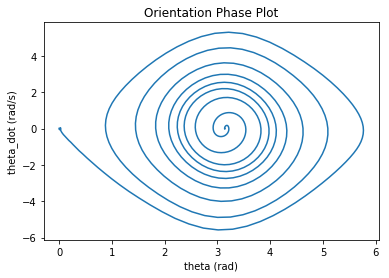

In [12]:
plt.plot(theta, theta_dot)
plt.xlabel("theta (rad)")
plt.ylabel("theta_dot (rad/s)")
plt.title("Orientation Phase Plot")

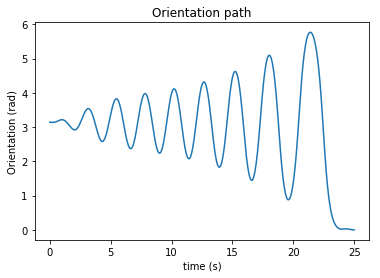

In [13]:
plt.plot(t, theta)
plt.xlabel("time (s)")
plt.ylabel("Orientation (rad)")
plt.title("Orientation path")

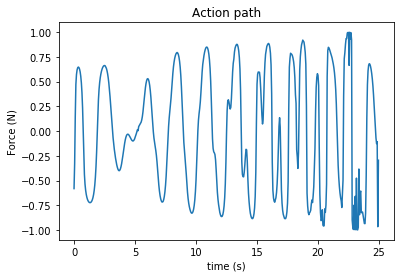

In [14]:
plt.plot(t[:-1], us)
plt.xlabel("time (s)")
plt.ylabel("Force (N)")
plt.title("Action path")

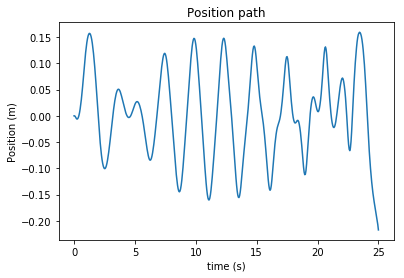

In [15]:
plt.plot(t, x)
plt.xlabel("time (s)")
plt.ylabel("Position (m)")
plt.title("Position path")

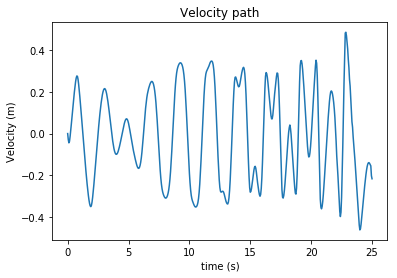

In [16]:
plt.plot(t, x_dot)
plt.xlabel("time (s)")
plt.ylabel("Velocity (m)")
plt.title("Velocity path")

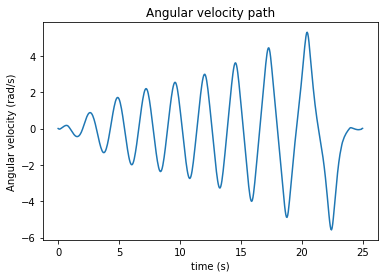

In [17]:
plt.plot(t, theta_dot)
plt.xlabel("time (s)")
plt.ylabel("Angular velocity (rad/s)")
plt.title("Angular velocity path")

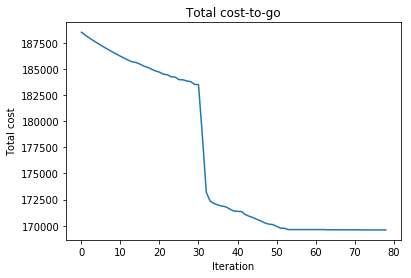

In [18]:
plt.plot(J_hist)
plt.xlabel("Iteration")
plt.ylabel("Total cost")
plt.title("Total cost-to-go")